<a href="https://colab.research.google.com/github/Bensmail-anis/Autoregressive-Character-Level-Language-Modeling/blob/main/notebooks/Exploring_more_about_MLP_Weight_Management_Batch_Normalization_Diagnostic_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the previous notebook, we implemented an MLP entirely from scratch, without relying on pre-built PyTorch classes. In this continuation, we maintain the same approach, diving deeper into advanced techniques such as weight initialization, batch normalization, and diagnostic tools to analyze neural network behavior, focusing on gradients and data flow. Additionally, we will prepare and split the dataset similarly to the previous implementation to ensure consistency in the process.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## **MLP Initialization with Batch Normalization and Weight Management**

This section sets up the initial components for our Multi-Layer Perceptron (MLP), focusing on parameter initialization and the introduction of batch normalization. We define n\_embd as the embedding dimensionality and n\_hidden as the number of neurons in the hidden layer. The embedding matrix C and weight matrices W1, W2 are initialized using Gaussian distributions. To stabilize activations and gradients, W1 is scaled by (5/3)/sqrt(n\_embd \* block\_size), inspired by He initialization, particularly suited for tanh activations, which are sensitive to input variance. We omit the bias term b1 since batch normalization inherently centers activations by subtracting the mean.

Batch normalization parameters bngain and bnbias are introduced for scaling and shifting post-normalization outputs. The running statistics bnmean\_running and bnstd\_running track the moving averages of batch statistics to stabilize inference when batch data is unavailable. All model parameters are stored in the parameters list, and their gradients are enabled using p.requires\_grad = True. This design efficiently prepares the model for stable training by leveraging both optimized weight initialization and batch normalization mechanisms, essential for training deep neural networks.

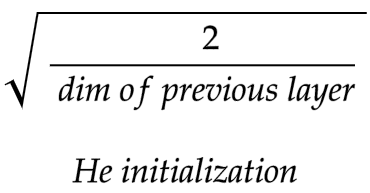

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


## **Training the MLP with Batch Normalization, Forward and Backward Passes**

In this section, we train the MLP model over max\_steps iterations, using a mini-batch approach to optimize the model. Each iteration constructs a batch from the training data Xtr and Ytr using the torch.randint function to sample indices. The model performs a forward pass where the input characters are embedded using C\[Xb\], and the embeddings are concatenated into a single vector with .view(emb.shape\[0\], -1), ensuring the correct shape for matrix multiplication.

The pre-activation hpreact is calculated by a linear transformation of the concatenated embeddings with W1. Batch normalization is applied next: we compute the batch mean and standard deviation using hpreact.mean(0, keepdim=True) and hpreact.std(0, keepdim=True), respectively, ensuring the normalized output preserves the same dimensionality. This normalization step is followed by scaling and shifting using bngain and bnbias. The running statistics (bnmean\_running and bnstd\_running) are updated using a moving average with a decay factor of 0.999, allowing the model to smoothly transition to using fixed statistics during inference , this is a typical implementation of momentum

Following the normalization, a non-linearity is introduced with torch.tanh to introduce non-linear behavior in the hidden layer, and then a final linear transformation is applied with W2 and the bias b2 to produce the logits. The loss is calculated using F.cross\_entropy(logits, Yb), which is a standard loss function for classification tasks.

In the backward pass, gradients are cleared with p.grad = None for all parameters before computing the gradients of the loss with respect to the parameters using loss.backward(). The model parameters are updated using gradient descent with a learning rate schedule: initially set to 0.1 for the first 100,000 steps, then decaying to 0.01 for the remaining steps. Every 10,000 iterations, the current loss is printed to monitor progress, and the loss value (in logarithmic scale) is stored in lossi for later analysis.

This training loop efficiently updates the model's parameters while incorporating batch normalization and proper learning rate decay, contributing to stable and effective training.

In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


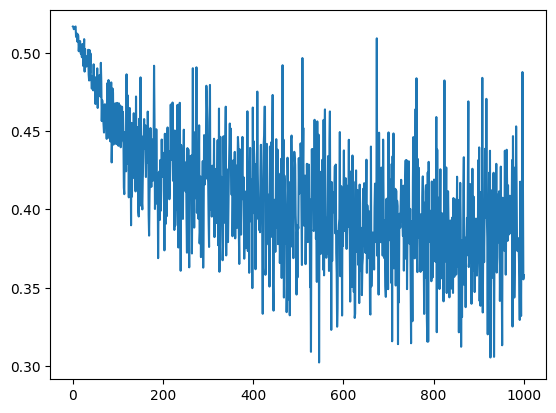

In [16]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training for later inference "we dont need it since we were calculating bnstd_running ,bnmean_running"

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


## Evaluating the Model: Loss Calculation for Train, Validation, and Test Splits
In this section, we define the function split_loss decorated with @torch.no_grad() to disable gradient tracking during evaluation. This decorator ensures that no unnecessary gradients are computed, which is computationally efficient during the evaluation phase. The function takes in the split parameter, which can be one of 'train', 'val', or 'test', to evaluate the model on the corresponding dataset.

For each split, the function retrieves the appropriate input-output pair (x, y) from Xtr, Ytr for training, Xdev, Ydev for validation, and Xte, Yte for testing. The embeddings of the input characters are extracted from C and reshaped into a 2D tensor using .view(emb.shape[0], -1), ensuring the correct shape for matrix multiplication. The hidden layer pre-activation (hpreact) is computed using the matrix multiplication of the embedded inputs and the weight matrix W1. Batch normalization is applied using the running statistics (bnmean_running and bnstd_running) that were previously accumulated during training.

The pre-activated output is passed through the tanh activation function to introduce non-linearity. Then, a final linear transformation is applied using W2 and the bias b2 to obtain the logits, which are then passed through the cross-entropy loss function (F.cross_entropy(logits, y)) to compute the loss for the current split. The loss for the current split is printed for monitoring purposes.

The split_loss function is called for both the 'train' and 'val' splits, allowing us to track the performance of the model on both training and validation datasets. This evaluation step is essential for assessing how well the model generalizes and helps identify any overfitting or underfitting issues.

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


## loss logs

Here's a detailed explanation of how each issue was addressed in the previous trials

### 1\. **Original Initialization**
Training Loss: 2.1245
Validation Loss: 2.1682
*   **Problem:** The model starts with random weight initialization. This can often lead to inefficient training, especially if the initial weights are too large or too small, leading to vanishing or exploding gradients during training.
    
*   **Fix:** In the next steps, the initialization of weights is improved. In the original initialization, the weights for layers were initialized randomly, leading to suboptimal performance.
    

### 2\. **Fix Softmax Confidently Wrong**
Training Loss: 2.0700
Validation Loss: 2.1300
*   **Problem:** Softmax was likely misapplied in the original model, leading to incorrect probabilities. If softmax is misused, it can distort the output distribution, making the model unable to properly optimize the loss function.
```python    
loss = F.cross_entropy(logits, Yb)  # The cross_entropy function includes softmax
```

*   **Effect:** This allowed the model to use the correct probability distributions, improving the training and validation losses.
    

### 3\. **Fix Tanh Layer Too Saturated at Init**
Training Loss: 2.0356
Validation Loss: 2.1027
*   **Problem:** The tanh activation function was too saturated at the start. This can happen if the weights are initialized too large, leading the outputs of the neurons to saturate at -1 or 1, making it difficult for the model to learn because the gradients become too small (vanishing gradient problem).

```python    
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)

```    
*   **Effect:** This led to less saturation in the tanh function, making the gradients flow better and allowing the network to learn more effectively.
    

### 4\. **Use Semi-Principled "Kaiming Initialization" Instead of Hacky Init**
Training Loss: 2.0377
Validation Loss: 2.1070
*   **Problem:** The initial weight distribution was arbitrary and not well-suited for the activation function used (tanh in this case), which led to suboptimal learning.
    
```python
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)

```    
*   **Effect:** This helped stabilize the gradient flow, which contributed to a reduction in both training and validation losses. Kaiming initialization scales the weights appropriately depending on the number of input and output units of each layer.
    

### 5\. **Add Batch Normalization Layer**
Training Loss: 2.0668
Validation Loss: 2.1048

*   **Problem:** The network’s internal distribution of activations might have been unstable, leading to slower training and gradient issues. Batch normalization helps stabilize learning by normalizing the output of each layer.

```python
bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.std(0, keepdim=True)
hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
with torch.no_grad():
  bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
```
  
*   **Explanation:** Batch normalization is applied by subtracting the mean and dividing by the standard deviation of the hidden activations. The running mean and standard deviation are updated during training to be used during validation, ensuring the normalization is consistent across different splits.
        
*   bngain and bnbias are used to scale and shift the normalized values, allowing the model to retain the ability to scale the activations after normalization.
        
*   **Effect:** Adding batch normalization helps stabilize the activations during training, speeding up convergence, and possibly preventing overfitting. While the improvement in training loss isn't drastic here, this technique is known to have long-term benefits in terms of faster convergence and stability in training.


In [ ]:
#PYTORCHIFYING -----------

## Building more layers :

we define a deeper neural network architecture by manually implementing layers using Python classes, mimicking the nn.Module API in PyTorch. we begin with a Linear class, representing a fully connected layer. The BatchNorm1d class implements batch normalization, normalizing inputs by adjusting their mean and variance per feature, with running statistics updated during training using a momentum term for inference. The Tanh class applies the hyperbolic tangent activation function. The network architecture consists of an embedding layer (C matrix for character embeddings), followed by multiple hidden layers made of Linear, BatchNorm1d, and Tanh components, and a final output layer with batch normalization. The learnable parameters of the network are the embedding weights and those of each layer (weights, gamma, and beta), and all layers are designed to be trainable via backpropagation.

In [9]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3 , and we did( / fan_in**0.5) already in the linear class

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

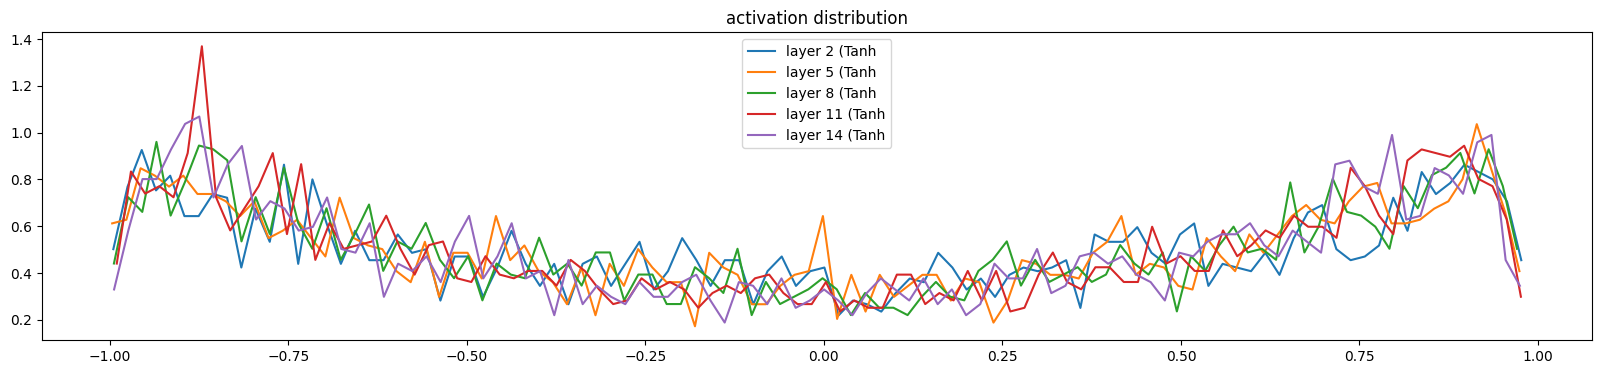

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

The histograms density plots of activations for each hidden layer using the Tanh activation function show that the mean activations are close to zero, and the standard deviation is consistent across layers, ranging from approximately 0.63 to 0.65. The percentage of saturated activations (where the values are near -1 or +1) decreases as we move deeper into the network. For example, layer 2 has 2.78% saturated, while layer 14 has 1.88%. These observations suggest that the network is learning more effectively as the deeper layers exhibit less saturation, which helps avoid the vanishing gradient problem and improves gradient flow during backpropagation. The plot illustrates this by visualizing the distribution of activations across layers, showing how the activations are distributed and the degree of saturation at each layer.

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

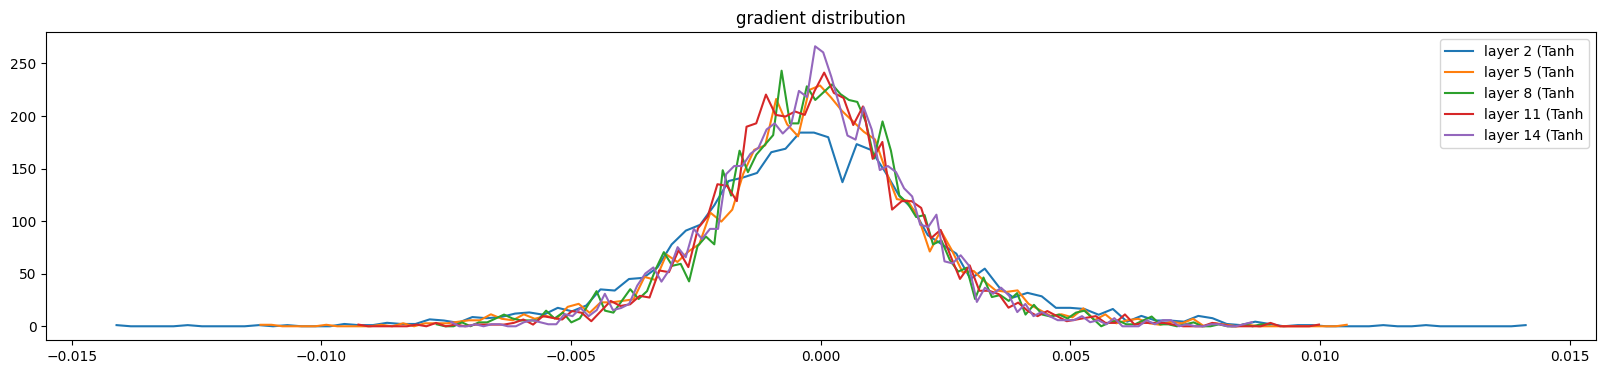

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

The histogram density plots of gradients for each hidden layer using the Tanh activation function shows that the gradients have a mean close to zero and a standard deviation that steadily decreases as we move deeper into the network. For example, the gradient standard deviation starts at 2.6407e-03 in layer 2 and reduces to 1.9524e-03 in layer 14. This indicates that as the network trains, the gradients become smaller in magnitude, which can help to stabilize training and reduce the risk of exploding gradients. The plot visualizes the distribution of gradients across layers, demonstrating how the gradient values are spread and how their scale diminishes progressively deeper in the network. This suggests effective gradient flow and less chance of vanishing gradients as training progresses.

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672203e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


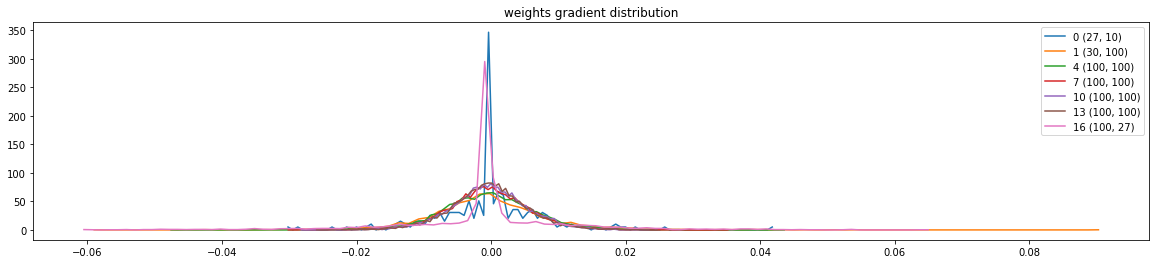

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

The histogram density plots visualization and printed statistics show the distribution of gradients for each weight matrix in the model, with a focus on the gradient-to-data ratio. For each weight matrix, the mean of the gradients is close to zero, suggesting that updates are balanced. The standard deviation of the gradients is relatively small, reflecting stable gradient updates across the layers. The gradient-to-data ratio, which compares the standard deviation of the gradients to that of the weights, provides insight into the update magnitude relative to the weights’ scale. Layers with a higher ratio, such as the final weight matrix (100, 27), indicate a larger relative gradient update compared to the weight values, which might influence the learning dynamics. The histograms visually confirm the distribution of these gradients across the layers, offering a deeper understanding of the gradient flow and its impact on training stability.

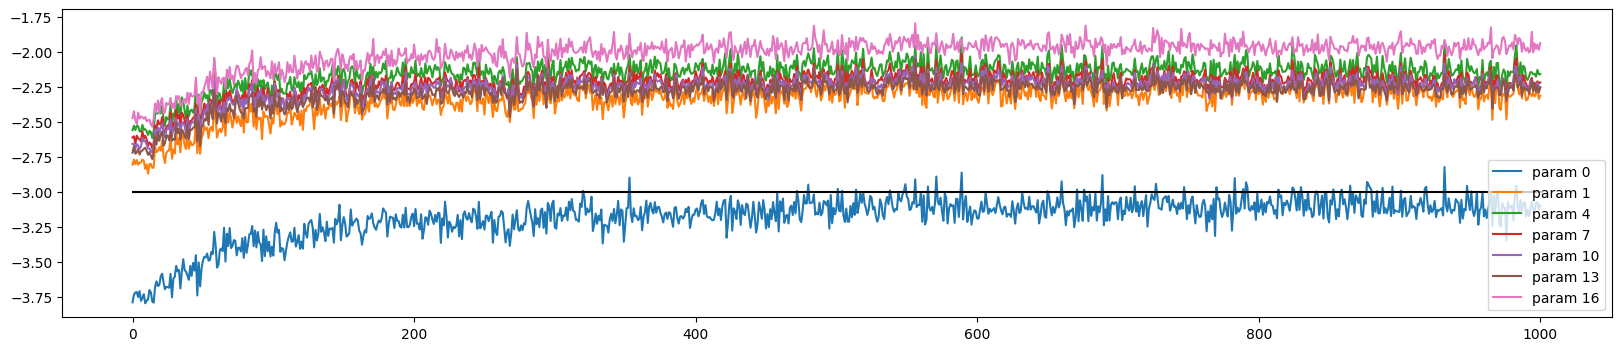

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
mmyan.
seelendhnyal.
rethrsjendrleg.
ade.
kdieliin.
miloen.
ekeisean.
xarlelleimhlara.
noshdh.
rgshiries.
kin.
reneliqxnthacfiu.
zayvde.
jymeli.
ehs.
kay.
mistoyan.
hal.
salyansuiezajelveu.
